# MARKET BASKET ANALYSIS USING FP-GROWTH

# 1. My motivation

I was inspired to do this analysis when I worked for a retailer 2 years ago. The idea behind is to utilise the transactional data to identify products usually sold together. This information is useful for upsaling by (i) displaying these products closedly, (ii) improving salesperson's recomendations to customers, etc.

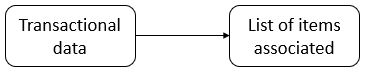

Because of data privacy policy, I can not publish my original work here. Also, my previous work was limited regarding running time as I used Apriori. I, therefore, try to redo this analysis here using FP Growth on the dataset of a UK-based and non-store online retail (see 5. References for data source).

# 2. About market basket analysis:
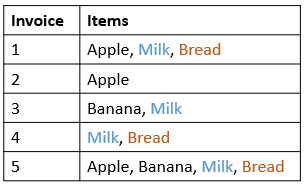
Take the above table as an example to understand the measurements more easily:
- Support (product X) is intuitively the probability that product X is purchased
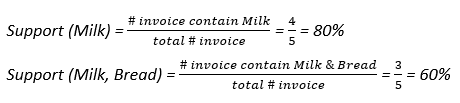
- Confidence (X->Y) is intuitively the probability that customers buy product Y given that they purchased product X
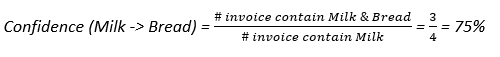
- Lift (X->Y) measures the extend to which the items are related. To calculate lift, the join probability is divided by individual probability
    + lift > 1 then X & Y are positively correlated
    + lift = 1 then X & Y are independent
    + lift < 1 then X & Y are negatively related
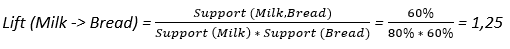

Take a closed look at the meaning of these metrics, we can intuitively see that the support may be low (if you want to account for low sales products) but confidence must be high and lift must be > 1

# 3. Time to explore & clean data

In [1]:
# Packages to use
import pandas as pd
import numpy as np
import os
import seaborn as sns
! pip install pyfpgrowth
import pyfpgrowth

In [2]:
# Import data in a dataframe and have a glimpse of data
os.chdir('D:\Personal portfolio')
raw_data = pd.read_csv('market_basket_analysis_data.csv')
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
raw_data.info() # 2 columns to use (InvoiceNo & StockCode) are not null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Check unique value of each variable
raw_data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [5]:
# test group by
test_df = raw_data

In [6]:
# Transform the data format as required by FP-Growth: [[item1, item2], [item1, item3, item5], ...]

# Group items by invoice
reduced_data = raw_data[['InvoiceNo','StockCode']].drop_duplicates() # for pivot to work, index & column must identify a row
pivot_reduced_data = reduced_data.pivot(index ='InvoiceNo', columns = 'StockCode', values ='StockCode').fillna(0)
pivot_reduced_data.head()

StockCode,10002,10080,10120,10123C,10123G,10124A,10124G,10125,10133,10134,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Convert dataframe into a list
input_list = pivot_reduced_data.values.tolist()
# Remove 0 from the list
for invoice in range(len(input_list)):
    try:
        while True:
            input_list[invoice].remove(0)
    except ValueError:
        pass
    invoice+=1
input_list[0:3] # check the format of the first 3 invoices

[['21730', '22752', '71053', '84029E', '84029G', '84406B', '85123A'],
 ['22632', '22633'],
 ['21754',
  '21755',
  '21777',
  '22310',
  '22622',
  '22623',
  '22745',
  '22748',
  '22749',
  '48187',
  '84879',
  '84969']]

In [8]:
len(input_list) # check the total number of invoice

25900

# 4. The model & result

In [21]:
# Create patterns with items that appear in at least 203 invoices (support >= 5%)
frequent_pattern = pyfpgrowth.find_frequent_patterns(input_list,203)
frequent_pattern

{('22601',): 204,
 ('23190',): 204,
 ('22465',): 205,
 ('22094',): 205,
 ('22422',): 205,
 ('48116',): 205,
 ('21955',): 206,
 ('20733',): 206,
 ('22430',): 206,
 ('85131D',): 206,
 ('20674',): 206,
 ('23050',): 206,
 ('22809',): 207,
 ('22626',): 207,
 ('22743',): 207,
 ('23156',): 207,
 ('23426',): 207,
 ('22792',): 208,
 ('23504',): 208,
 ('48129',): 209,
 ('22800',): 209,
 ('21922',): 209,
 ('22676',): 209,
 ('22377',): 209,
 ('22921',): 210,
 ('22839',): 211,
 ('21243',): 211,
 ('22548',): 211,
 ('22974',): 211,
 ('22045',): 211,
 ('22562',): 211,
 ('23163',): 211,
 ('23215',): 211,
 ('23032',): 211,
 ('22466',): 212,
 ('22485',): 212,
 ('21991',): 212,
 ('22207',): 212,
 ('21902',): 212,
 ('22636',): 212,
 ('23014',): 212,
 ('21390',): 213,
 ('21500',): 213,
 ('23101',): 213,
 ('23352',): 213,
 ('84969',): 214,
 ('21984',): 214,
 ('22421',): 214,
 ('21508',): 214,
 ('22982',): 214,
 ('20668',): 215,
 ('22024',): 215,
 ('21745',): 215,
 ('22426',): 215,
 ('22302',): 215,
 ('23091'

In [22]:
# Check number of frequent item sets
len(frequent_pattern)

1789

In [23]:
# Create pattern of items with confidence >= 60%
confident_pattern = pyfpgrowth.generate_association_rules(frequent_pattern,confidence_threshold=0.6)
confident_pattern

{('22920',): (('22919',), 0.8565573770491803),
 ('22917',): (('22919',), 0.8838174273858921),
 ('22916', '22917'): (('22918',), 0.918918918918919),
 ('22916', '22918'): (('22917',), 0.9532710280373832),
 ('22917', '22918'): (('22916',), 0.9444444444444444),
 ('84596G',): (('84596B',), 0.8259109311740891),
 ('21899',): (('21900',), 0.7147887323943662),
 ('23266',): (('23263',), 0.684375),
 ('23264',): (('23266',), 0.6766666666666666),
 ('82578',): (('82580',), 0.7222222222222222),
 ('23254',): (('23256',), 0.758957654723127),
 ('23256',): (('23254',), 0.6196808510638298),
 ('21239',): (('21240',), 0.6763754045307443),
 ('21240',): (('21239',), 0.6333333333333333),
 ('21901',): (('21900',), 0.6806451612903226),
 ('23170', '23171'): (('22699',), 0.6490683229813664),
 ('23170', '23172'): (('23171',), 0.9485294117647058),
 ('23171', '23172'): (('23170',), 0.9148936170212766),
 ('84032A',): (('DOT',), 0.6825396825396826),
 ('22962',): (('22963',), 0.6418732782369146),
 ('22963',): (('22962',

In [24]:
# Check number of confident set
len(confident_pattern)

251

In [43]:
# Get the result data
result_data = pd.DataFrame({'Antecedent':confident_pattern.keys(),'Consequence & Confidence':confident_pattern.values()})
result_data.head(10)

,Antecedent,Consequence & Confidence
0,"(22920,)","((22919,), 0.8565573770491803)"
1,"(22917,)","((22919,), 0.8838174273858921)"
2,"(22916, 22917)","((22918,), 0.918918918918919)"
3,"(22916, 22918)","((22917,), 0.9532710280373832)"
4,"(22917, 22918)","((22916,), 0.9444444444444444)"
5,"(84596G,)","((84596B,), 0.8259109311740891)"
6,"(21899,)","((21900,), 0.7147887323943662)"
7,"(23266,)","((23263,), 0.684375)"
8,"(23264,)","((23266,), 0.6766666666666666)"
9,"(82578,)","((82580,), 0.7222222222222222)"


# 5. Some final thoughts

For this analysis, I used Stock Code to identify each product. However, you can flexibly use a product group as an identifer given that products in a group can replace each other (I mean the same bottles with different color can be considered the same)

# 6. References

Data source: 
https://www.kaggle.com/carrie1/ecommerce-data/version/1

About market basket analysis:
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-market-basket-analysis/
https://www.softwaretestinghelp.com/fp-growth-algorithm-data-mining/
https://thinkingneuron.com/how-to-do-association-rule-mining-using-fp-growth-in-python/
https://www.kaggle.com/daasshukla/basic-exploratory-analysis
https://karan18csu103.medium.com/market-basket-analysis-usinhhg-association-rule-mining-with-apriori-eclat-and-fpgrowth-algorithm-6a9737c1f573